In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import calendar
from matplotlib import pyplot as plt
import scipy.stats as stats
import glob

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from mpl_toolkits.mplot3d import Axes3D  #3Dplot
import seaborn as sns
import japanize_matplotlib


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Mean Absolute Error(MAE)用 
from sklearn.metrics import mean_absolute_error 
# Root Mean Squared Error(RMSE)用 
from sklearn.metrics import mean_squared_error


In [2]:
files = glob.glob('../../../卒論関連書類/データ/king_history/king_history1/*')
version = len(files)-1
df_king =pd.read_csv(f'../../../卒論関連書類/データ/king_history/king_history1/king{version}.csv',converters={'DateTime':pd.to_datetime})

In [87]:
# 取引量と再エネ誤差の比較
def func_drowgraf_torihiki():
    # 時間前市場取引量補正係数
    chan_num = 1

    files = glob.glob('../../../卒論関連書類/データ/king_history/king_history1/*')
    version = len(files)-1
    df_king =pd.read_csv(f'../../../卒論関連書類/データ/king_history/king_history1/king{version}.csv',converters={'DateTime':pd.to_datetime})


    cols = ['intra_volume（MWh/h）','太陽光誤差合算(実績-想定)(kWh)(ならし)',
        '風力誤差合算(実績-想定)(kWh)(ならし)', '太陽光絶対値誤差合算(実績-想定)(kWh)',
        '風力絶対値誤差合算(実績-想定)(kWh)',]
    df_select = df_king[cols].dropna()

    # ならし効果なしの合算、取引量不足分

    df_select['ならしなし取引量不足分(kWh)'] = chan_num*df_select['intra_volume（MWh/h）']*1000- df_select['太陽光絶対値誤差合算(実績-想定)(kWh)']-df_select['風力絶対値誤差合算(実績-想定)(kWh)']


    df_select['ならしあり取引量不足分(kWh)'] = chan_num*df_select['intra_volume（MWh/h）']*1000- np.abs(df_select['太陽光誤差合算(実績-想定)(kWh)(ならし)'])-np.abs(df_select['風力誤差合算(実績-想定)(kWh)(ならし)'])

    # ならし効果なしのグラフ
    x_ = df_select['ならしなし取引量不足分(kWh)']
    plt.hist(x_,bins=100,color='0.6')
    plt.axvline(x=0,color='0.1')
    plt.xlabel('取引量-再エネ誤差(kWh)')
    plt.ylabel('該当コマ数')
    plt.title('再エネ予測誤差と時間前市場の取引量')
    plt.savefig('../../../卒論関連書類/画像/卒論用画像/再エネ誤差(太陽光と風力)と時間前市場の取引量.png')
    plt.show()


    num_non_narashi = len(df_select[df_select['ならしなし取引量不足分(kWh)']<0])
    print(f'ならしなし{num_non_narashi/len(df_select)*100}%')


    # 
    x_ = df_select['ならしあり取引量不足分(kWh)']
    plt.hist(x_,bins=100,color='0.6')
    plt.axvline(x=0,color='0.1')
    plt.xlabel('取引量-再エネ誤差(kWh)')
    plt.ylabel('該当コマ数')
    plt.title('再エネ予測誤差と時間前市場の取引量(ならし効果あり)')
    plt.savefig('../../../卒論関連書類/画像/卒論用画像/再エネ誤差(太陽光と風力)と時間前市場の取引量(ならし効果あり).png')
    plt.show()

    num_narashi =len(df_select[df_select['ならしあり取引量不足分(kWh)']<0])

    print('ならしあり',num_narashi/len(df_select)*100,'%')

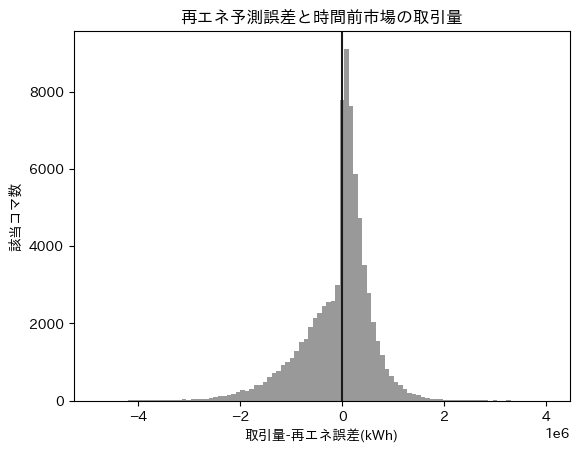

ならしなし42.5968938718628%


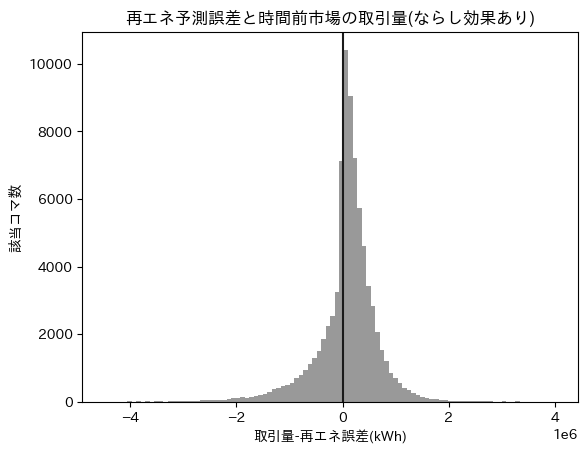

ならしあり 31.04370425240744 %


In [88]:
func_drowgraf_torihiki()

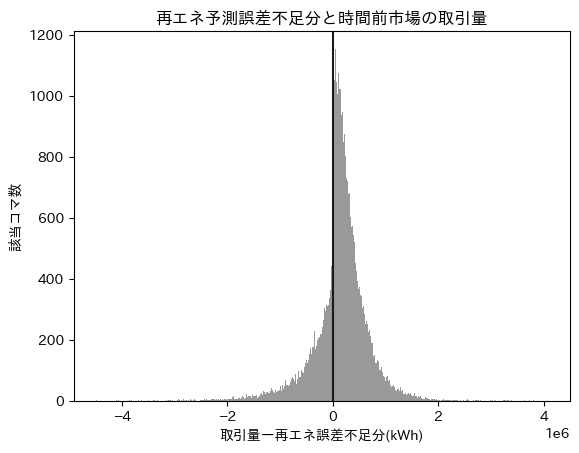

不足コマ数26.359401875729766%


In [91]:
# 再エネ予測誤差不足分　ならしなし
# 補正係数
chan = 1

files = glob.glob('../../../卒論関連書類/データ/king_history/king_history1/*')
version = len(files)-1
df_king =pd.read_csv(f'../../../卒論関連書類/データ/king_history/king_history1/king{version}.csv',converters={'DateTime':pd.to_datetime})

col_names = ['intra_volume（MWh/h）','九電太陽光error(実績-想定)(kWh)',
       '九電風力error(実績-想定)(kWh)', '東電太陽光error(実績-想定)(kWh)',
       '東電風力error(実績-想定)(kWh)', '関電太陽光error(実績-想定)(kWh)',
       '関電風力error(実績-想定)(kWh)', '中国太陽光error(実績-想定)(kWh)',
       '中国風力error(実績-想定)(kWh)', '太陽光誤差合算(実績-想定)(kWh)(ならし)',
       '風力誤差合算(実績-想定)(kWh)(ならし)']


df_fusoku = df_king[col_names].dropna()
df_fusoku['intra_volume（MWh/h）'] = df_fusoku['intra_volume（MWh/h）']*1000*chan
area_names = ['九電','東電','関電','中国']
for name in area_names:
# name = '東電'
       df_fusoku.loc[df_fusoku[f'{name}太陽光error(実績-想定)(kWh)']>0,[f'{name}太陽光error(実績-想定)(kWh)']] = 0
       df_fusoku.loc[df_fusoku[f'{name}風力error(実績-想定)(kWh)']>0,[f'{name}風力error(実績-想定)(kWh)']] = 0

       array =df_fusoku['intra_volume（MWh/h）'].values

       # print(array.mean())
       df_fusoku['intra_volume（MWh/h）'] = array + df_fusoku[f'{name}太陽光error(実績-想定)(kWh)'].values + df_fusoku[f'{name}風力error(実績-想定)(kWh)'].values
       # df_fusoku['']

plt.hist(df_fusoku['intra_volume（MWh/h）'].values,bins=1000,color='0.6')
plt.axvline(x=0,color='0.1')
plt.title('再エネ予測誤差不足分と時間前市場の取引量')
plt.xlabel('取引量ー再エネ誤差不足分(kWh)')
plt.ylabel('該当コマ数')
plt.savefig('../../../卒論関連書類/画像/卒論用画像/予測誤差不足分と時間前市場の取引量.png')
plt.show()

lack_percentage = len(df_fusoku[df_fusoku['intra_volume（MWh/h）']<0])/len(df_fusoku)*100
print(f'不足コマ数{lack_percentage}%')

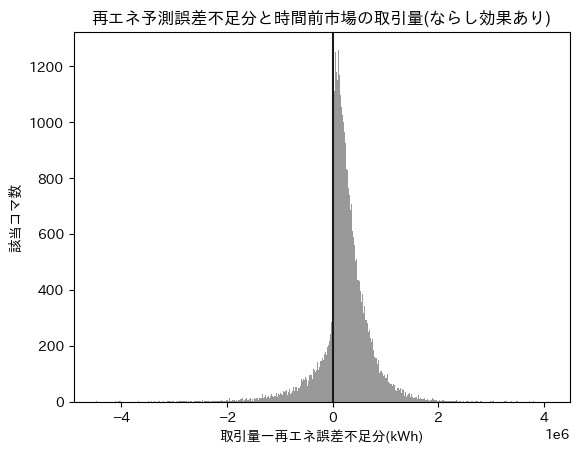

不足コマ数16.331655136913206%


In [93]:
# 再エネ予測誤差不足分　ならしあり
# 補正係数


chan = 1

files = glob.glob('../../../卒論関連書類/データ/king_history/king_history1/*')
version = len(files)-1
df_king =pd.read_csv(f'../../../卒論関連書類/データ/king_history/king_history1/king{version}.csv',converters={'DateTime':pd.to_datetime})

col_names = ['intra_volume（MWh/h）','九電太陽光error(実績-想定)(kWh)',
       '九電風力error(実績-想定)(kWh)', '東電太陽光error(実績-想定)(kWh)',
       '東電風力error(実績-想定)(kWh)', '関電太陽光error(実績-想定)(kWh)',
       '関電風力error(実績-想定)(kWh)', '中国太陽光error(実績-想定)(kWh)',
       '中国風力error(実績-想定)(kWh)', '太陽光誤差合算(実績-想定)(kWh)(ならし)',
       '風力誤差合算(実績-想定)(kWh)(ならし)']


df_fusoku = df_king[col_names].dropna()
df_fusoku['intra_volume（MWh/h）'] = df_fusoku['intra_volume（MWh/h）']*1000*chan

df_fusoku.loc[df_fusoku['太陽光誤差合算(実績-想定)(kWh)(ならし)']>0,['太陽光誤差合算(実績-想定)(kWh)(ならし)']] = 0
df_fusoku.loc[df_fusoku['風力誤差合算(実績-想定)(kWh)(ならし)']>0,['風力誤差合算(実績-想定)(kWh)(ならし)']] = 0

array =df_fusoku['intra_volume（MWh/h）'].values

# print(array.mean())
df_fusoku['intra_volume（MWh/h）'] = array + df_fusoku['太陽光誤差合算(実績-想定)(kWh)(ならし)'].values + df_fusoku['風力誤差合算(実績-想定)(kWh)(ならし)'].values
# df_fusoku['']

plt.hist(df_fusoku['intra_volume（MWh/h）'].values,bins=1000,color='0.6')
plt.axvline(x=0,color='0.1')
plt.title('再エネ予測誤差不足分と時間前市場の取引量(ならし効果あり)')
plt.xlabel('取引量ー再エネ誤差不足分(kWh)')
plt.ylabel('該当コマ数')
plt.savefig('../../../卒論関連書類/画像/卒論用画像/予測誤差不足分と時間前市場の取引量(ならしあり).png')
plt.show()

lack_percentage = len(df_fusoku[df_fusoku['intra_volume（MWh/h）']<0])/len(df_fusoku)*100
print(f'不足コマ数{lack_percentage}%')

In [48]:
# 再エネ予測誤差不足分(ならしなし)
df_king.columns

Index(['DateTime', 'intra_price(円/kWh)', 'spot_price(円/kWh)',
       'gap_price[intra-spot](円/kWh)', 'intra_volume（MWh/h）',
       'spot_volume(kWh)', '北電太陽光想定(kWh)', '北電風力想定(kWh)', '北電太陽光実績(kWh)',
       '北電風力実績(kWh)', '九電太陽光想定(kWh)', '九電太陽光実績(kWh)', '九電風力想定(kWh)',
       '九電風力実績(kWh)', '東電太陽光想定(kWh)', '東電太陽光実績(kWh)', '東電風力想定(kWh)',
       '東電風力実績(kWh)', '関電太陽光想定(kWh)', '関電太陽光実績(kWh)', '関電風力想定(kWh)',
       '関電風力実績(kWh)', '中国太陽光想定(kWh)', '中国風力想定(kWh)', '中国太陽光実績(kWh)',
       '中国風力実績(kWh)', '北海道予備率(%)', '東北予備率(%)', '東京予備率(%)', '中部予備率(%)',
       '北陸予備率(%)', '関西予備率(%)', '中国予備率(%)', '四国予備率(%)', '九州予備率(%)', '認可出力合計',
       '低下量合計', '停止・低下ユニット数合計', '北電太陽光error(実績-想定)(kWh)',
       '北電風力error(実績-想定)(kWh)', '九電太陽光error(実績-想定)(kWh)',
       '九電風力error(実績-想定)(kWh)', '東電太陽光error(実績-想定)(kWh)',
       '東電風力error(実績-想定)(kWh)', '関電太陽光error(実績-想定)(kWh)',
       '関電風力error(実績-想定)(kWh)', '中国太陽光error(実績-想定)(kWh)',
       '中国風力error(実績-想定)(kWh)', '絶対値北電太陽光error(実績-想定)(kWh)',
       '絶対値北電風力error(実績-想定)

In [67]:
df_fusoku

,intra_volume（MWh/h）,九電太陽光error(実績-想定)(kWh),九電風力error(実績-想定)(kWh),東電太陽光error(実績-想定)(kWh),東電風力error(実績-想定)(kWh),関電太陽光error(実績-想定)(kWh),関電風力error(実績-想定)(kWh),中国太陽光error(実績-想定)(kWh),中国風力error(実績-想定)(kWh),太陽光誤差合算(実績-想定)(kWh)(ならし),風力誤差合算(実績-想定)(kWh)(ならし)
0,29352.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-48.0,0.0,15797.195000
1,25629.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-1371.0,0.0,14959.670000
2,23422.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-5228.0,0.0,9111.870000
3,27016.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-4484.0,0.0,12244.950000
4,21248.000000,0.0,0.000000,0.0,0.0,0.0,-3497.0,0.0,-6055.0,0.0,4196.435000
...,...,...,...,...,...,...,...,...,...,...,...
79754,384011.852764,0.0,-576.147236,0.0,0.0,0.0,0.0,0.0,-9112.0,0.0,23403.852764
79755,654973.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-6527.0,0.0,23885.208319
79756,437376.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-11174.0,0.0,19987.191793
79757,453473.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-13027.0,0.0,12554.958776


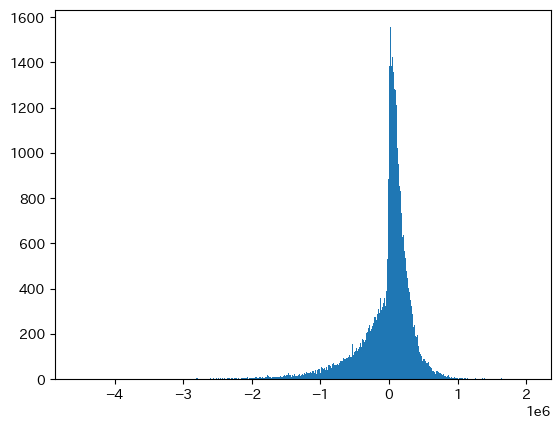

In [76]:
plt.hist(df_fusoku['intra_volume（MWh/h）'],bins=1000)
plt.show()

In [ ]:
df_king.columns

In [3]:
cols = ['intra_volume（MWh/h）','太陽光誤差合算(実績-想定)(kWh)(ならし)',
       '風力誤差合算(実績-想定)(kWh)(ならし)', '太陽光絶対値誤差合算(実績-想定)(kWh)',
       '風力絶対値誤差合算(実績-想定)(kWh)',]
df_select = df_king[cols].dropna()

In [15]:
# ならし効果なしの合算、取引量不足分

df_select['ならしなし取引量不足分(kWh)'] = df_select['intra_volume（MWh/h）']*1000- df_select['太陽光絶対値誤差合算(実績-想定)(kWh)']-df_select['風力絶対値誤差合算(実績-想定)(kWh)']


df_select['ならしあり取引量不足分(kWh)'] = df_select['intra_volume（MWh/h）']*1000- np.abs(df_select['太陽光誤差合算(実績-想定)(kWh)(ならし)'])-np.abs(df_select['風力誤差合算(実績-想定)(kWh)(ならし)'])

In [16]:
x = df_select[
    # 'ならしなし取引量不足分(kWh)'
    'intra_volume（MWh/h）'
    ]

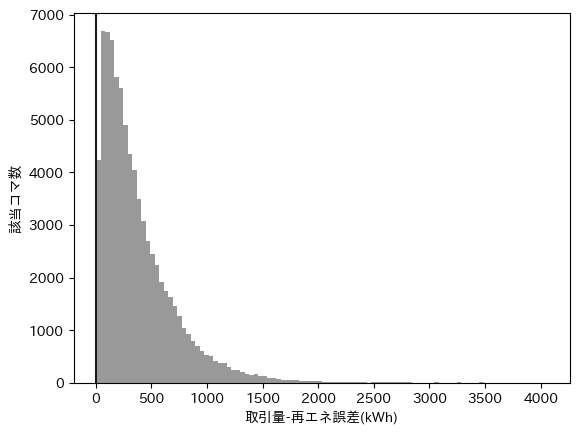

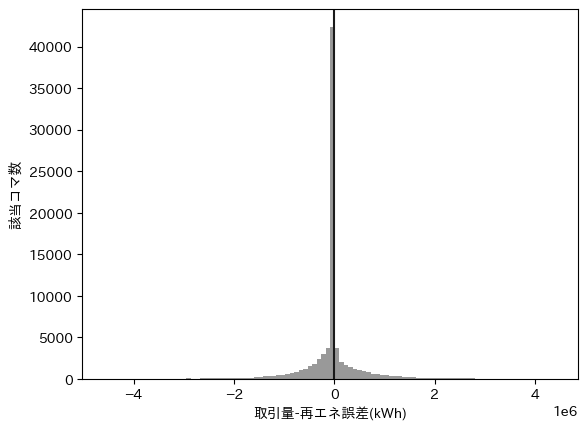

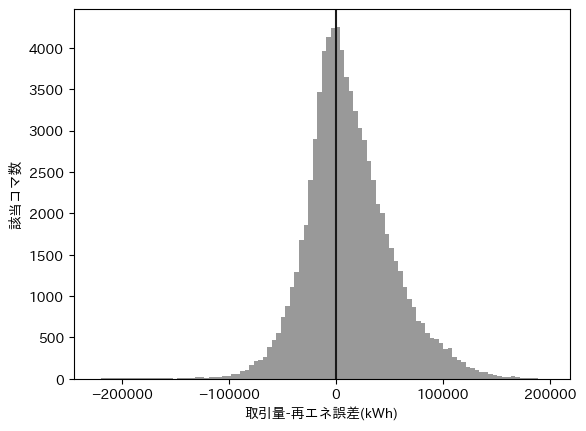

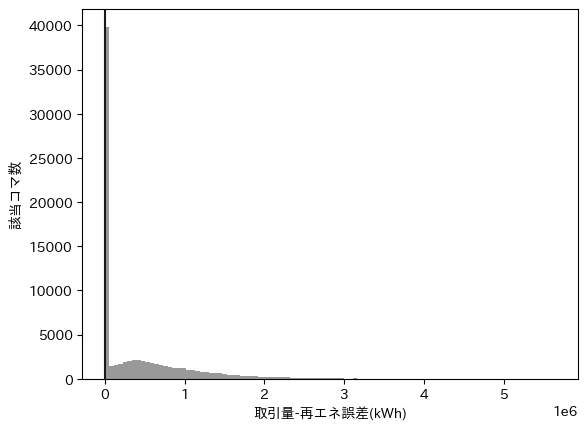

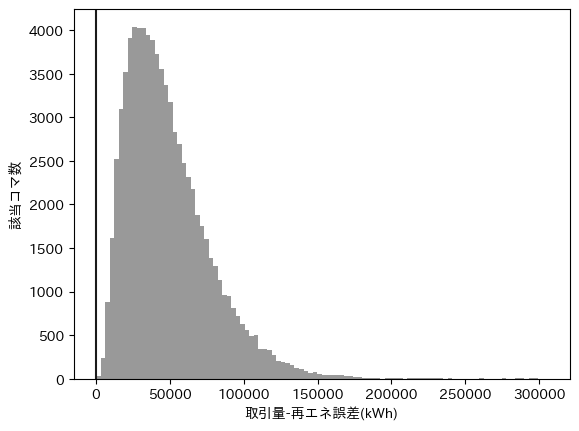

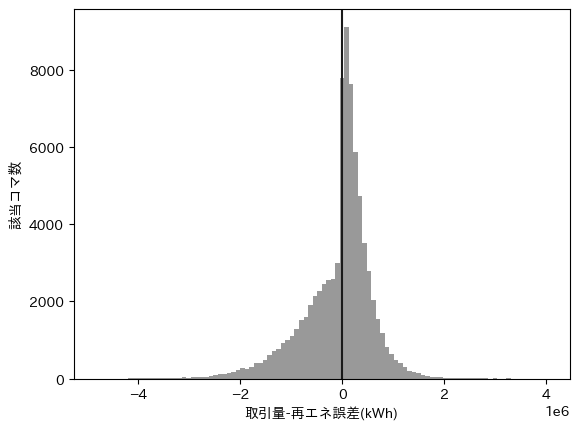

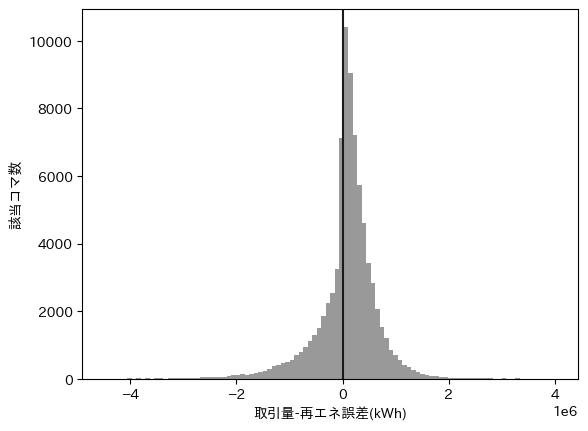

In [31]:
for name in df_select.columns:
    x_ = df_select[
        # 'ならしなし取引量不足分(kWh)'
        # 'intra_volume（MWh/h）'
        f'{name}'
        ]
    plt.hist(x_,bins=100,color='0.6')
    plt.axvline(x=0,color='0.1')
    plt.xlabel('取引量-再エネ誤差(kWh)')
    plt.ylabel('該当コマ数')
    plt.show()


num_non_narashi = len(df_select[df_select['ならしなし取引量不足分(kWh)']<0])
num_narashi =len(df_select[df_select['ならしあり取引量不足分(kWh)']<0])

In [23]:
plt.hist(df_select[''])


num_non_narashi/len(df_select)*100

42.5968938718628

In [24]:
num_narashi/len(df_select)*100

31.04370425240744

In [32]:
df_select.columns

Index(['intra_volume（MWh/h）', '太陽光誤差合算(実績-想定)(kWh)(ならし)',
       '風力誤差合算(実績-想定)(kWh)(ならし)', '太陽光絶対値誤差合算(実績-想定)(kWh)',
       '風力絶対値誤差合算(実績-想定)(kWh)', 'ならしなし取引量不足分(kWh)', 'ならしあり取引量不足分(kWh)'],
      dtype='object')

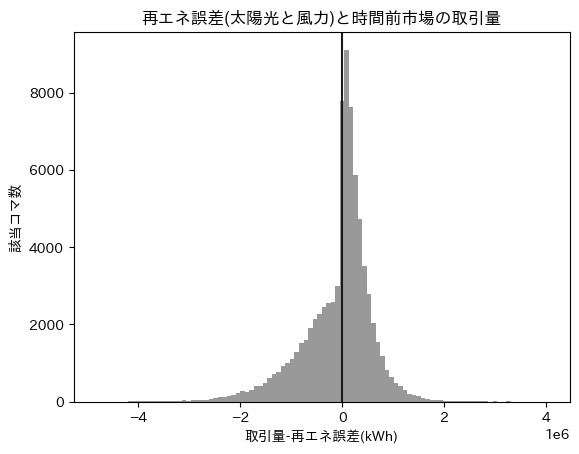

42.5968938718628

In [36]:
# ならし効果なしのグラフ
x_ = df_select['ならしなし取引量不足分(kWh)']
plt.hist(x_,bins=100,color='0.6')
plt.axvline(x=0,color='0.1')
plt.xlabel('取引量-再エネ誤差(kWh)')
plt.ylabel('該当コマ数')
plt.title('再エネ誤差(太陽光と風力)と時間前市場の取引量')
plt.show()


num_non_narashi = len(df_select[df_select['ならしなし取引量不足分(kWh)']<0])
print(f'ならしなし{num_non_narashi/len(df_select)*100}%')

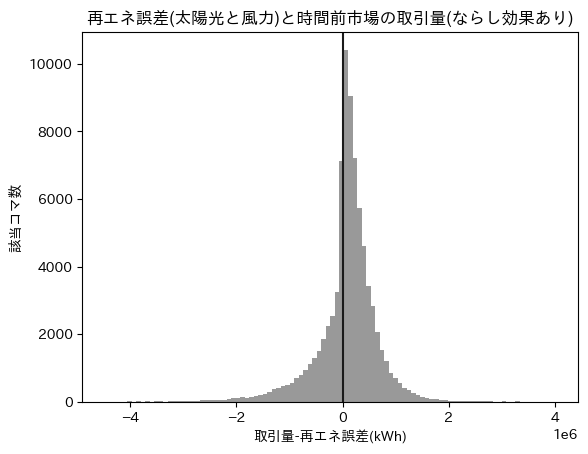

ならしあり 31.04370425240744 %


In [40]:
# 
x_ = df_select['ならしあり取引量不足分(kWh)']
plt.hist(x_,bins=100,color='0.6')
plt.axvline(x=0,color='0.1')
plt.xlabel('取引量-再エネ誤差(kWh)')
plt.ylabel('該当コマ数')
plt.title('再エネ誤差(太陽光と風力)と時間前市場の取引量(ならし効果あり)')
plt.show()

num_narashi =len(df_select[df_select['ならしあり取引量不足分(kWh)']<0])

print('ならしあり',num_narashi/len(df_select)*100,'%')